<h1>Import</h1>

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
from static_data import HAIRCUTS

import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from datetime import datetime

from model.config import Config

from analysis_tools.compute_data import compute_collateral_value, compute_funding_dataframe
from analysis_tools.loading_data import loading_data
from static_data import START_TIME, END_TIME
from strategy.max_function_rate_sec import MaxFundingRateSec
from strategy.best_gain import BestGain


<h1>Process data</h1>

In [3]:
dataset = loading_data()

collateral_value = compute_collateral_value()

config = Config(
    dataset=dataset, 
    tokens=list(collateral_value.keys()),
    start_date=datetime.strptime(START_TIME, "%d-%m-%Y"),
    end_date=datetime.strptime(END_TIME, "%d-%m-%Y"),
)

funding_df = compute_funding_dataframe(dataset)

<h1>Run Strategy</h1>

In [4]:
strat = BestGain(funding_df, config)

In [5]:
strat.apply()

<h1>Visualisation of the result</h1>

In [6]:
result = strat.result

In [7]:
invested_amount_usd = 250_000 * 8 + 500_000

In [8]:
invested = result.loc[result['ACTION']=="INVESTED"]

In [9]:
pnl = pd.pivot_table(data=invested, values='potential_gain_usd', index=["date_daily"], columns=[], aggfunc="sum", fill_value=0)

pnl.index = pd.to_datetime(pnl.index, format="%d-%m-%Y")

print(pnl)
print("\n"*4)
print(f"         Summarize           ")
print("\n"*1)
print(f"Invested ($) : {invested_amount_usd:.2f}")
print(f"     PNL ($) : {pnl.sum()[0]:.2f}")
print(f"     APY (%) : {invested_amount_usd/pnl.sum()[0]:.2f}")

            potential_gain_usd
date_daily                    
2024-01-01         1689.051124
2024-02-01          501.042802
2024-03-01         4110.035264
2024-04-01         4543.192487
2024-05-01          479.664922
...                        ...
2024-04-30          597.712978
2024-05-30          933.174665
2024-01-31          514.109698
2024-03-31         4549.436504
2024-05-31          757.747970

[152 rows x 1 columns]





         Summarize           


Invested ($) : 2500000.00
     PNL ($) : 233120.42
     APY (%) : 10.72


In [10]:
pnl_by_token = pd.pivot_table(data=invested, values='potential_gain_usd', index=["date_daily"], columns=["token"], aggfunc="sum", fill_value=0)

pnl_by_token.index = pd.to_datetime(pnl_by_token.index, format="%d-%m-%Y")

pnl_by_token

token,AAVEUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,MASKUSDT,SOLUSDT,USDT,XRPUSDT
date_daily,,,,,,,,,
2024-01-01,134.905264,0.000000,124.956550,106.177086,188.393030,232.482915,252.202346,547.220000,102.713933
2024-02-01,0.000000,71.633925,74.842542,43.807008,24.900649,66.805817,70.498623,148.554237,0.000000
2024-03-01,0.000000,181.018446,592.379158,628.873823,386.634291,623.635255,599.299291,1098.195000,0.000000
2024-04-01,0.000000,0.000000,541.997894,1073.643895,508.889362,593.563793,840.942543,984.155000,0.000000
2024-05-01,53.627218,0.000000,102.603974,34.655172,57.538306,22.168742,59.735972,110.541828,38.793708
...,...,...,...,...,...,...,...,...,...
2024-04-30,20.199439,47.683133,106.303554,0.000000,81.985593,56.533903,98.113258,145.923452,40.970645
2024-05-30,0.000000,142.055203,0.000000,138.328258,238.460500,0.000000,123.005704,291.325000,0.000000
2024-01-31,0.000000,73.285072,50.803699,22.163515,76.283402,68.085106,74.604081,148.884824,0.000000


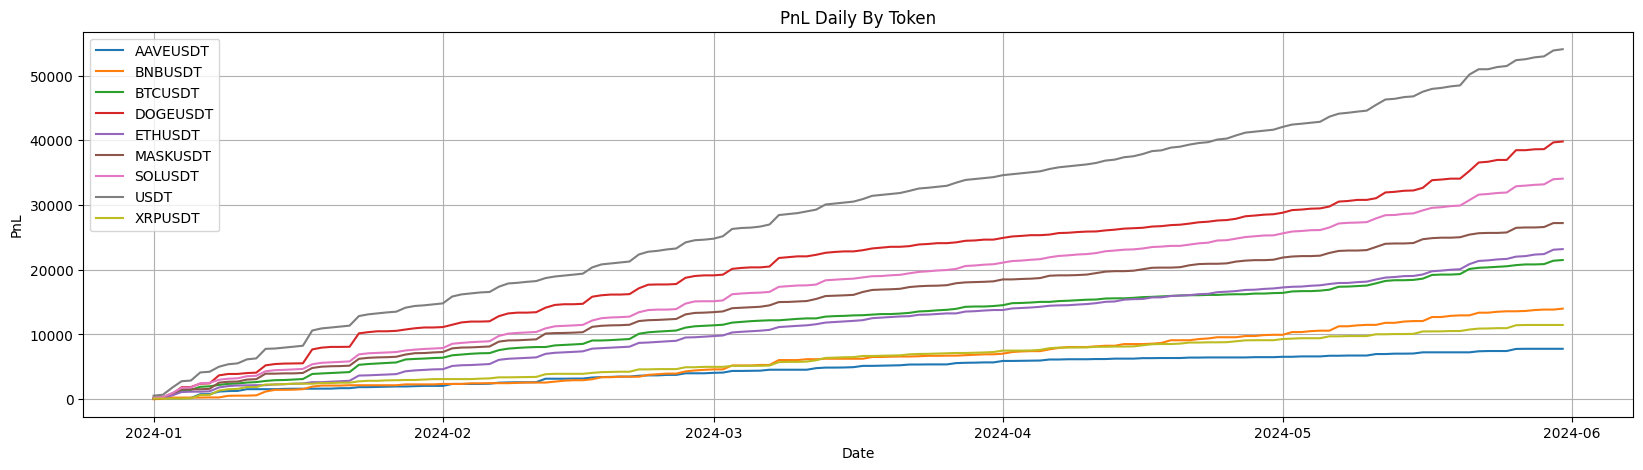

In [11]:
plt.figure(figsize=(20, 5))
for col in pnl_by_token.columns.tolist():
    plt.plot(pd.date_range(start='2024-01-01', end="2024-05-31", freq='D'), pnl_by_token[col].cumsum(), label=col)
plt.title('PnL Daily By Token')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.legend()
plt.grid(True) 
plt.show()

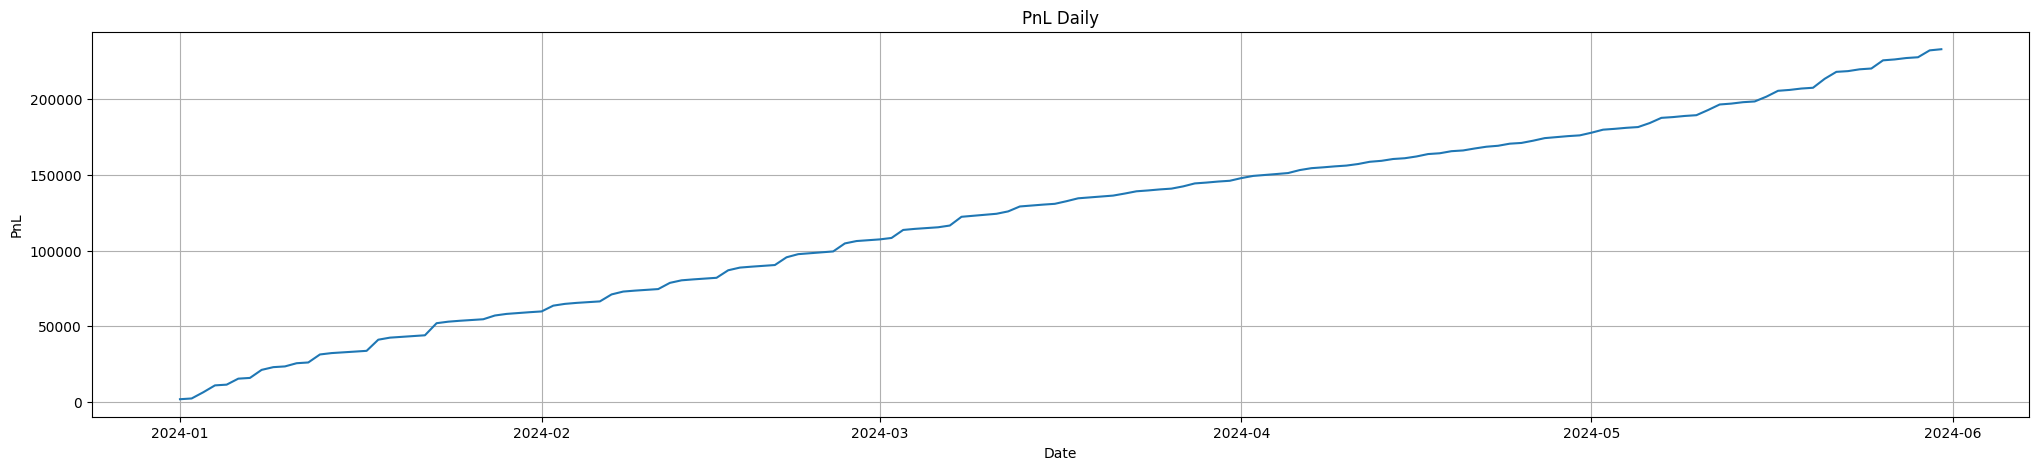

In [12]:
plt.figure(figsize=(25, 5))
plt.plot(pd.date_range(start='2024-01-01', end="2024-05-31", freq='D'), pnl['potential_gain_usd'].cumsum())
plt.title('PnL Daily')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)
plt.show()

In [15]:
invested = pd.pivot_table(data=result.loc[result["ACTION"]=="INVESTED"], values='collateral_needed_usd', index=["timestamp"], columns=["ACTION"], aggfunc="sum", fill_value=0)

In [16]:
posted = pd.pivot_table(data=result.loc[result["ACTION"]=="POSTED"], values='collateral_value_usd', index=["timestamp"], columns=["ACTION"], aggfunc="sum", fill_value=0)

In [17]:
collateral_management = pd.merge(invested.reset_index(), posted.reset_index(), on="timestamp", how="inner")

In [18]:
collateral_management["ratio collateralization (%)"] = collateral_management["INVESTED"] / collateral_management["POSTED"]

In [19]:
collateral_management

ACTION,timestamp,INVESTED,POSTED,ratio collateralization (%)
0,2024-01-01 08:00:00,1.755075e+06,2.194108e+06,0.799904
1,2024-01-01 16:00:00,1.773077e+06,2.258531e+06,0.785058
2,2024-01-02 00:00:00,1.804440e+06,2.286597e+06,0.789138
3,2024-01-02 08:00:00,1.826857e+06,2.317216e+06,0.788384
4,2024-01-02 16:00:00,1.798326e+06,2.268196e+06,0.792844
...,...,...,...,...
450,2024-05-30 08:00:00,2.219857e+06,3.167904e+06,0.700734
451,2024-05-30 16:00:00,2.256499e+06,3.220303e+06,0.700710
452,2024-05-31 00:00:00,2.229756e+06,3.209798e+06,0.694672
453,2024-05-31 08:00:00,2.224139e+06,3.135421e+06,0.709359
